*Carmen Carolina Ramírez Acosta*   
***

# **Tarea 01:** Redes neuronales para tareas de aprendizaje supervisado.

***

Se realizará una tarea de clasificación multiclase. La base de datos con la que se desarrolla el presente trabajo se titula "Dry Bean Data Set" y fue obtenida del repositorio [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Dry+Bean+Dataset).

##**Preámbulo**



Vamos a comenzar por importar todas las paqueterías que vamos a utilizar a lo largo de esta tarea. 

In [1]:
import pandas as pd
from pandas import ExcelWriter
from pandas import ExcelFile

import numpy as np
np.random.seed(1234)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import torch 
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from collections import OrderedDict
from torch import nn
from torch import optim
import torch.nn.functional as F
from tqdm import tqdm

import time

##**Sobre la base de datos**

Lo primero que haremos será leer la base de datos con la que trabajaremos para luego imprimir las primeras observaciones de la misma, esto con el objetivo de familiarizarnos con la información que maneja. 

In [2]:
#Leeemos la base de datos
original_data = pd.read_excel('Dry_Bean_Dataset.xlsx')
#Desplegamos las primeras observaciones
original_data.head()

,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4,Class
0,28395,610.291,208.178117,173.888747,1.197191,0.549812,28715,190.141097,0.763923,0.988856,0.958027,0.913358,0.007332,0.003147,0.834222,0.998724,SEKER
1,28734,638.018,200.524796,182.734419,1.097356,0.411785,29172,191.272750,0.783968,0.984986,0.887034,0.953861,0.006979,0.003564,0.909851,0.998430,SEKER
2,29380,624.110,212.826130,175.931143,1.209713,0.562727,29690,193.410904,0.778113,0.989559,0.947849,0.908774,0.007244,0.003048,0.825871,0.999066,SEKER
3,30008,645.884,210.557999,182.516516,1.153638,0.498616,30724,195.467062,0.782681,0.976696,0.903936,0.928329,0.007017,0.003215,0.861794,0.994199,SEKER
4,30140,620.134,201.847882,190.279279,1.060798,0.333680,30417,195.896503,0.773098,0.990893,0.984877,0.970516,0.006697,0.003665,0.941900,0.999166,SEKER


Para la generación de esta base de datos, en el sitio web se comenta que se capturaron 13,611 imágenes, cada una correspondiente a un grano de frijol. Cada grano de frijol pertenecía a uno de siente tipos de frijol disponibles. Con ayuda de las fotografías se midieron (de manera digital) 16 características relativas a cada grano: doce de ellas correspondientes a las dimensiones y cuatro más correspondientes a la forma que presentaba el grano; esta información que se registró en la base de datos que estudiaremos.  

A continuación, presentaré una breve descripción de cada una de las variables de la base de datos. 

* **Area (A)**: Se refiere al área de la zona que ocupaba el frijol en la imagen, en número de pixeles.  
* **Perimeter (P)**: La circunferencia del frijol, que se define como la longitud de su borde. 
* **MajorAxisLength (L)**: Distancia entre los extremos de la línea más larga que puede ser dibujada sobre el frijol.
* **MinorAxisLength (I)**: Distancia entre los extremos de la línea más larga, perpendicular al eje principal, que puede ser dibujada sobre el frijol. 
* **Aspect ratio (K)**: $\frac{L}{I}$, define la relación entre las variables L e I. 
* **Eccentricity (Ec)**: Excentricidad de la elipse que delimita el frijol. 
* **ConvexArea (C)**: Número de pixeles que hay en el polígono convexo más pequeño que puede encerrar al área del frijol.
* **EquivalentDiameter (Ed)**: El diámetro de un círculo que tiene la misma área que el área del frijol.
* **Extent (Ex)**: El cociente entre el número de pixeles que hay en el rectángulo que rodea al frijol y el área del frijo. 
* **Solidity (S)**: El cociente entre los pixeles que hay en la cáscara convexa del frijol y lo que hay en los frijoles.  
* **Roundness (R)**: El resultado de la fórmula $4 \pi A  P^2$. 
* **ShapeFactor1 (SF1)**: Factor de forma 1. 
* **ShapeFactor1 (SF2)**: Factor de forma 2. 
* **ShapeFactor1 (SF3)**: Factor de forma 3. 
* **ShapeFactor1 (SF4)**: Factor de forma 4. 
* **Class**: Tipo de frijol. Es una variable categórica que puede tomar cualquiera de los siguientes siete valores: *Seker, Barbunya, Bombay, Cali, Dermosan, Horoz* y *Sira*.
 


El objetivo de este trabajo es intentar predecir a qué clase de frijol pertenece un grano dado que conocemos la información de las otras 16 variables referentes a su aspecto. Es decir, la variable *Class* será nuestra etiqueta y el resto de variables serán nuestros rasgos. Para poder trabajar con mayor soltura, cambiaremos los valores de la variable *Class* a enteros. Mediante la siguiente equivalencia

In [3]:
clases = sorted(original_data['Class'].unique())        #Clases de frijol
codes = np.arange(0, len(clases))                       #Su código equivalente, en número

equivalencia = {'Clases': clases, 'Códigos':codes}
pd.DataFrame(equivalencia)

,Clases,Códigos
0,BARBUNYA,0
1,BOMBAY,1
2,CALI,2
3,DERMASON,3
4,HOROZ,4
5,SEKER,5
6,SIRA,6


In [4]:
#Copiamos el data frame
data = pd.DataFrame.copy(original_data)
#Convertimos las clases a sus códigos
data['Class'] = data['Class'].astype('category')
data['Class'] = data['Class'].cat.codes
#Mostramos el resultado
data.head()

,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4,Class
0,28395,610.291,208.178117,173.888747,1.197191,0.549812,28715,190.141097,0.763923,0.988856,0.958027,0.913358,0.007332,0.003147,0.834222,0.998724,5
1,28734,638.018,200.524796,182.734419,1.097356,0.411785,29172,191.272750,0.783968,0.984986,0.887034,0.953861,0.006979,0.003564,0.909851,0.998430,5
2,29380,624.110,212.826130,175.931143,1.209713,0.562727,29690,193.410904,0.778113,0.989559,0.947849,0.908774,0.007244,0.003048,0.825871,0.999066,5
3,30008,645.884,210.557999,182.516516,1.153638,0.498616,30724,195.467062,0.782681,0.976696,0.903936,0.928329,0.007017,0.003215,0.861794,0.994199,5
4,30140,620.134,201.847882,190.279279,1.060798,0.333680,30417,195.896503,0.773098,0.990893,0.984877,0.970516,0.006697,0.003665,0.941900,0.999166,5



Como se puede ver a continuación, la base de datos contiene 13611 registros, 17 variables y no tiene valores faltantes.

In [5]:
samples, n_features = original_data.shape
print("Número de observaciones:",samples)
print("Número de variables:",n_features)
print("\nValores faltantes por variable: ")
print(original_data.isnull().sum())

Número de observaciones: 13611
Número de variables: 17

Valores faltantes por variable: 
Area               0
Perimeter          0
MajorAxisLength    0
MinorAxisLength    0
AspectRation       0
Eccentricity       0
ConvexArea         0
EquivDiameter      0
Extent             0
Solidity           0
roundness          0
Compactness        0
ShapeFactor1       0
ShapeFactor2       0
ShapeFactor3       0
ShapeFactor4       0
Class              0
dtype: int64


Así las cosas, podemos escribir a nuestro conjunto de datos como
$$\mathcal{D} = \{(\mathbf x, y) \in \mathcal{X}\times C\}, $$

donde
* $\mathcal{X} \subset \mathbb{R}^{13611 \times 16}$ es el conjunto de rasgos, representado por carcaterísticas de la dimensión y forma de los frijoles. 
* $C = \{0,1 ,2 , 3, 4, 5, 6\}$ es el conjunto que contiene las posibles clases a las que puede pertenecer un frijol.

## **Análisis exploratorio y preparación de datos**

###**Análisis exploratorio**

Realizaremos un histograma para cada una de las variables que componen nuestro conjunto de rasgos $\mathcal{X}$.

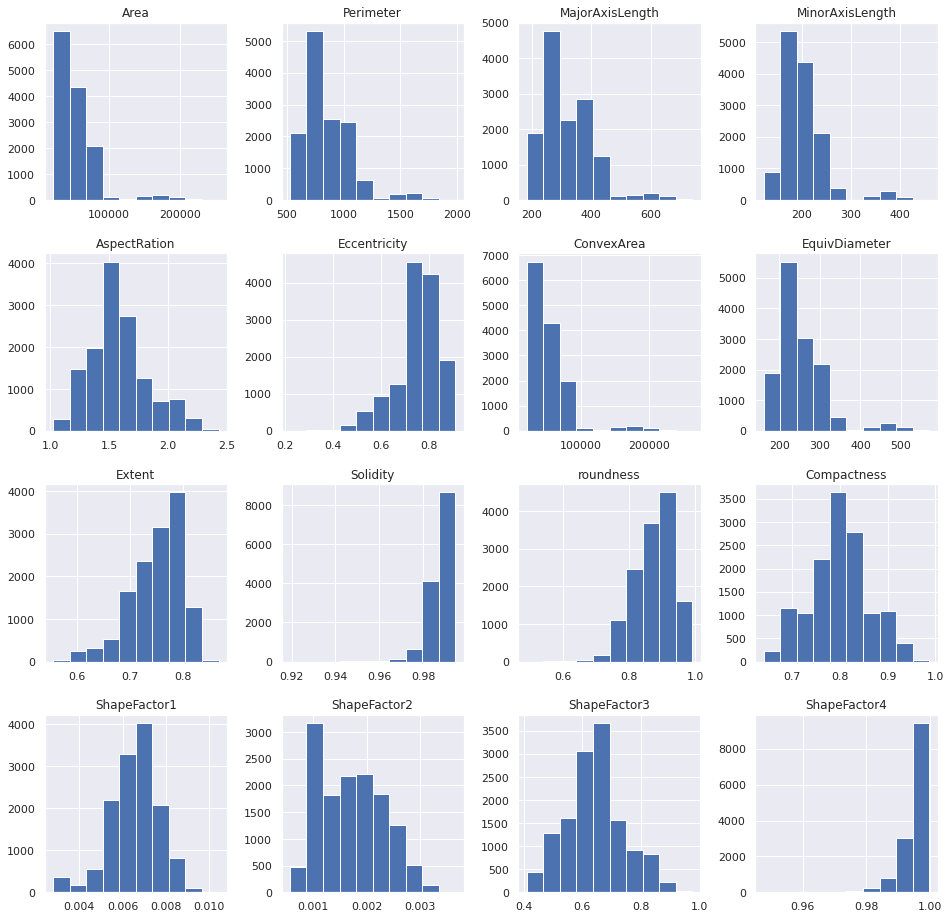

In [6]:
data.drop("Class",axis=1).hist(figsize=[16,16])
plt.show()

A continuación, obtengamos algunos estadísticos básicos para cada una de las variables.

In [7]:
data.drop('Class', axis=1).describe()

,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4
count,13611.000000,13611.000000,13611.000000,13611.000000,13611.000000,13611.000000,13611.000000,13611.000000,13611.000000,13611.000000,13611.000000,13611.000000,13611.000000,13611.000000,13611.000000,13611.000000
mean,53048.284549,855.283459,320.141867,202.270714,1.583242,0.750895,53768.200206,253.064220,0.749733,0.987143,0.873282,0.799864,0.006564,0.001716,0.643590,0.995063
std,29324.095717,214.289696,85.694186,44.970091,0.246678,0.092002,29774.915817,59.177120,0.049086,0.004660,0.059520,0.061713,0.001128,0.000596,0.098996,0.004366
min,20420.000000,524.736000,183.601165,122.512653,1.024868,0.218951,20684.000000,161.243764,0.555315,0.919246,0.489618,0.640577,0.002778,0.000564,0.410339,0.947687
25%,36328.000000,703.523500,253.303633,175.848170,1.432307,0.715928,36714.500000,215.068003,0.718634,0.985670,0.832096,0.762469,0.005900,0.001154,0.581359,0.993703
50%,44652.000000,794.941000,296.883367,192.431733,1.551124,0.764441,45178.000000,238.438026,0.759859,0.988283,0.883157,0.801277,0.006645,0.001694,0.642044,0.996386
75%,61332.000000,977.213000,376.495012,217.031741,1.707109,0.810466,62294.000000,279.446467,0.786851,0.990013,0.916869,0.834270,0.007271,0.002170,0.696006,0.997883
max,254616.000000,1985.370000,738.860153,460.198497,2.430306,0.911423,263261.000000,569.374358,0.866195,0.994677,0.990685,0.987303,0.010451,0.003665,0.974767,0.999733


Tanto en los histogramas, como el el cuadro anterior, se puede apreciar la variedad de rangos numéricos que poseen las variables. Por ejemplo, `ConvexArea` presenta valores mayores a $200000$, mientras que la variable `ShapeFactor1` contiene valores menores a $0.02$. Esto puede representar un inconveniente... Pero veremos más adelante cómo lidiar con esta situación. 

###**Preparación de datos**

Como se vio en la sección pasada, nuestra base de datos cuenta con 13611 registros, por lo que nos podemos permitir tomar aproximadamente $90\%$ del conjunto de datos para entrenar a la red neuronal (`train_data`) y el resto para hacer las pruebas y validaciones correspondientes(`test_data`). 

$$\mathcal{X} = \mathcal{X}_{train} \cup \mathcal{X}_{test}$$
$$C = C_{train} \cup C_{test}$$

In [8]:
mask = np.random.random(samples) < 0.9        #Máscara 90% 
train_data = data[mask]                       #90% datos de entrenamiento
test_data = data[~mask]                       #10% datos de prueba

Ha llgado el momento de manipular los datos con los que estaremos trabajando. Lo primero que hay que hacer es separar la etiqueta `Class` de los rasgos, de este modo podremos ver la *respuesta* sólo cuando sea necesario. Para hacer esta manipulación, nos ayudaremos de la clase `DataframaDataset`. 

Por otro lado, en análisis exploratorio de datos se observó que los rasgos manejan rangos numéricos muy variados. Esto puede representar un problema, pues podríamos estar dándole más peso a ciertas variables en la predicción, lo que sería incorrecto, ya que no sabemos a ciencia cierta qué variables son más relevantes en la categorización de las observaciones. Por lo tanto, estandarizaremos nuestros datos iniciales mediante la siguiente transformación
$$x \to \frac{x - \mu}{\sigma}$$
con $x$ una columna de rasgos de `data`, $\mu$ su media y $\sigma$ su desviación estándar. Esto no sólo es útil para mejorar la predicción, si no que además resulta ser más óptimo. 

In [9]:
class DataframeDataset(Dataset):

  def __init__(self, data, y_name, transform=None, target_transform=None):
    self.Y = torch.tensor(data[y_name].to_numpy(), dtype=torch.long)  #Convertimos los datos de salida a tensor
    aux = data.drop(y_name, axis=1).to_numpy()                        #Nos deshacemos de las respuestas en los rasgos
    self.X = torch.from_numpy(aux).to(dtype=torch.float32)            #Convertimos los datos de entrada a tensor
    self.transform = transform                                        #Definimos la trasnformación a aplicarle a los rasgos
    self.target_transform = target_transform                          #Definimos la trasnformación a apliacarle a los datos de salida

  def __len__(self):
    return self.Y.size()[0]

  def __getitem__(self, idx):                   
    x = self.X[idx, :]                                                
    y = self.Y[idx]
    if self.transform:                                                 #Si hay transformaciones, las aplicamos
      x = self.transform(x)
    if self.target_transform:
      y = self.target_transform(y)
    return x, y

In [10]:
X_train = train_data.drop('Class', axis=1)       #Le quito la columna que dice a qué clase pertenece, pues así se deben calcular la media y la desviación estándar de la transformación.
mean_data = X_train.mean(axis=0)                 #Saco la media de cada rasgo (por columna).
std_data = X_train.std(axis=0)                   #Saco la desviación estándar de rasgo (por columna).
#Defino la transformación para estandarizar los rasgos
tx = lambda x: (x - torch.tensor(mean_data, dtype=torch.float32))/torch.tensor(std_data, dtype=torch.float32)

In [11]:

#Definimos los conjuntos de entrenamiento y prueba como un objeto DataframeDataset, con las transformaciones pertinentes.
train_dataset = DataframeDataset(train_data, y_name='Class', transform=tx)
test_dataset = DataframeDataset(test_data, y_name='Class', transform=tx)


A continuación, dividiremos `test_data`en dos conjuntos: el de validación y el de prueba. La división se hará en partes iguales.

In [12]:
evens = list(range(0, len(test_dataset), 2))                  #Máscara de números pares
odds = list(range(1, len(test_dataset), 2))                   #Máscara de números impares
val_dataset = torch.utils.data.Subset(test_dataset, evens)    #Selección de datos de validación
test_dataset = torch.utils.data.Subset(test_dataset, odds)    #Selección de datos de prueba

Hagamos un conteo de la división de los datos que tenemos hasta ahora

In [13]:
n_train = len(train_dataset)
n_val = len(val_dataset)
n_test = len(test_dataset)

print("Datos en el conjunto de entrenamiento:",n_train)
print("Datos en el conjunto de validación:",n_val)
print("Datos en el conjunto de entrenamiento:",n_test)
print("Total de datos:",n_test+n_val+n_train)

Datos en el conjunto de entrenamiento: 12222
Datos en el conjunto de validación: 695
Datos en el conjunto de entrenamiento: 694
Total de datos: 13611


Haremos el entrenamiento con *mini batches* estocásticos, por lo que nuestro siguiente problema a resolver es la división de nuestro conjunto de entrenamiento en *mini batches* de tamaño `batch_size`, que en nuestro caso consideraremos 64. Es decir, buscamos que
$$\mathcal{X}_{train} = X_{(1)} \cup X_{(2)} \cup \cdots \cup X_{(n_{batch})}$$
donde ${n_{batch}}$ es el número de batches en que se particiona a $\mathcal{X}$. Realizaremos esto con ayuda del módulo `DataLoader`.

In [14]:
#Tamaño del bacth
batch_size = 64 

#División en mini-batches de tamaño batch_size, y los revolvemos (estocástico)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=1)

#Vemos cómo quedaron las dimensiones
train_features, train_labels = next(iter(train_dataloader))
print(f"Forma de un mini_batch (rasgos): {train_features.size()}")
print(f"Forma de un mini_batch (etiquetas): {train_labels.size()}")

Forma de un mini_batch (rasgos): torch.Size([64, 16])
Forma de un mini_batch (etiquetas): torch.Size([64])


## **Declaración de la red neuronal**


Defínase $a=<[n_0=16, 64,64,n_L=7], \{ReLU, ReLU, Linear\}>$, proponemos la red neuronal

$$f_a( \cdot |\theta): \mathbb{R}^{k \times n_0}\rightarrow [0,1]^{k \times n_L}$$

para la tarea de clasificación, donde $k$ es el tamaño del batch (nosotros lo fijaremos en 64).



In [15]:
n_features = n_features -1      #Número de rasgos: Número de variables menos la variable de la etiqueta
n_clases = len(clases)          #Número de etiquetas
N = [64, 64]

A continuación, con ayuda del módulo `nn`de Torch, definiremos la arquitectura de la red neuronal antes propuesta



In [16]:
#Definición de la red neuronal

model = nn.Sequential(OrderedDict([
    #Capa de entrada
    ('z1', nn.Linear(n_features, 64)),      
    ('h1', nn.ReLU()),
    #Capa oculta
    ('z2', nn.Linear(64, 64)),
    ('h2', nn.ReLU()),
    #Capa salida
    ('z3', nn.Linear(64, n_clases)),
]))

In [17]:
#Creamos un vector aleatorio de tamaño n_features y con él instanciamos el modelo
x = torch.randn(1, n_features) 
modelo = model(x)
#Imprimimos el modelo
print(model)

Sequential(
  (z1): Linear(in_features=16, out_features=64, bias=True)
  (h1): ReLU()
  (z2): Linear(in_features=64, out_features=64, bias=True)
  (h2): ReLU()
  (z3): Linear(in_features=64, out_features=7, bias=True)
)


## **Planteamiento del problema**

 Para entrenar nuestra red neuronal, vamos a utilizar la función Categorical Entropy Loss. Como sabemos, esta función consiste de una función de activación Softmax seguida de una función Cross-Entropy Loss. En consecuencia, la red neuronal $f_a$ definida anteriormente es ahora $g_a$ con 
 $$g_a(\cdot|\theta) = Softmax \circ f_a(\cdot|\theta)$$
Recordemos que la función Cross-Entropy Loss es útil en tareas de clasificaciones multiclase, como la que queremos llevar a cabo. 

La función Cross-Entropy Loss nos da una medida de qué tan distintos son los resultados que obtuvimos con nuestra red neuronal a los resultados verdaderos. Nuestro objetivo es entonces hallar el parámetro $\theta$ que minimice dicha función, es decir, 

$$\min_{\theta \in \mathbb{R}^{P([16, 64, 64, 7])}}CEL\left(\theta; Y_{(b)}, \hat{Y}_{(b)}\right) \qquad \forall b \in \{1, \cdots, n_{batch}\}$$

$$\hat{Y}_{(b)} = f_a\left(X_{(b)} |\theta\right)\quad Y_{(b)} \subset C.$$
con $C$ el conjunto de clases. 

Se eligió el algoritmo de optimización ADAM. 


In [25]:
#Definimos la función a optimizar
criterion = nn.CrossEntropyLoss()
#Definimos el algotimo de optimización con sus parámetos correspondientes. 
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0005)

In [19]:
def fit(model, dataloader, optimizer, criterion, pbar, train=True):
  #Inicilizamos la pérdida en 0.
  running_loss = 0.0 
  #Inicializamos los aciertos en 0.
  correct = 0
  #Inicializamos el total en 0.
  total = 0
  for i, data in enumerate(dataloader, 0):
    #Elegimos el batch
    X, Y = data
    if train:
      #Reinicia el gradiente
      optimizer.zero_grad() 
    #Hacemos el forward pass   
    pred = model(X) 
    #Evaluamos la calidad de la predicción con CEL
    loss = criterion(pred, Y) 
    if train:
      #Se calculan las derivadas
      loss.backward() 
      #Paso de optimización
      optimizer.step()

    #Aumentamos la pérdida.
    running_loss += loss.item()
    #Promediamos el error.
    avg_loss = running_loss/(i + 1)
    #Predecimos la etiqueta.
    probs = F.softmax(pred, 1)
    label = torch.argmax(probs, dim=1)
    #Si le atinamos a la categoría correcta, sumamos un acierto. 
    correct += torch.sum(label == Y).item()
    #Calculamos el total de predicciones que se hicieron. 
    total += Y.shape[0]
    #Calculamos la precisión de la red. 
    acc = correct/total
        
    pbar.set_postfix(avg_loss='{:.4f}'.format(avg_loss), acc='{:.4f}'.format(acc))
    pbar.update(Y.shape[0])
  return avg_loss, acc

## **Entrenamiento**

Ya tenemos todo listo para comenzar a entrenar nuestra red neuronal. A continuación se muestran los resultados obtenidos con 150 epochs. 

In [26]:
#Fijamos el número de epochs
EPOCHS = 150
#Inicializamos el reloj del tiempo de entrenamiento en ceros
train_time = 0

#Estas listas contendrán los valores de la pérdida y la precisión por cada epoch, respectivamente
epoch_loss = []
epoch_acc = []

#Estas listas contendrán los valores de la pérdida y la precisión por cada epoch, respectivamente, obtenidos en las validaciones
val_loss = []
val_acc = []

In [21]:
#Comenzamos a entrenar

for epoch in range(EPOCHS):
  #Registramos el momento en que inició la epoch
  start_time = time.time()
  with tqdm(total=n_train, position=0) as pbar_train:
    #Entrenamos
    pbar_train.set_description(f'Epoch {epoch + 1}/'+str(EPOCHS)+' - train')
    pbar_train.set_postfix(avg_loss='0.0', acc='0.0')
    loss_train, acc_train = fit(model, train_dataloader, optimizer, criterion, pbar_train)
    #Calculamos el tiempo de entrenamiento de la epoch y lo sumamos al tiempo total de entrenamiento
    train_time +=  time.time() - start_time
  with tqdm(total=n_val, position=0) as pbar_val:
    #Validamos
    pbar_val.set_description(f'Epoch {epoch + 1}/'+str(EPOCHS)+' - val')
    pbar_val.set_postfix(avg_loss='0.0', acc='0.0')
    loss_val, acc_val = fit(model, val_dataloader, optimizer, criterion, pbar_val, train=False)

  #Gardamos los resultados de pérdida y precisión, tanto de entrenamiento, como de validación.
  epoch_loss.append(loss_train)
  epoch_acc.append(acc_train)

  val_loss.append(loss_val)
  val_acc.append(acc_val)

#Imprimimos el tiempo total de entrenamiento
print("\n --- %s seconds ---", train_time)

Epoch 150/150 - val: 100%|██████████| 695/695 [00:00<00:00, 5617.32it/s, acc=0.9453, avg_loss=0.1707]


 --- %s seconds --- 351.31788873672485


Como se observa en la siguiente figura, los resultados son muy buenos. Tnemos una precisón por arriba de $0.9$ tanto en entrenamiento como en validación, a partir de la décima epoch... Además, sucede que los resultados de validación ¡son incluso más favorables que los de entrenamiento! 

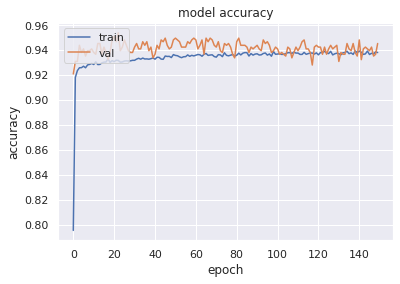

In [22]:
plt.plot(epoch_acc)
plt.plot(val_acc)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

En cuanto a la pérdida, el resultado también es muy bueno. Nos mantenemos por debajo de 0.2 desde las primeras epochs. Además, los resultados de validación se mantienen cercanos a los de entrenamiento, a partir de la epoch número 50 (aproximadamente) comienzan a tener pérdidas superiores a las de entrenmiento, pero como se observa, la diferencia no es muy significativa. En general, se observa la tendencia decreciente que buscábamos. 

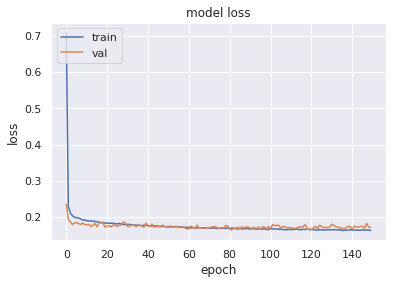

In [23]:
plt.plot(epoch_loss)
plt.plot(val_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## **El examen final: la prueba del modelo**

Finalmente, probamos el modelo con `test_dataloader`. 

In [27]:
running_loss = 0.0 
correct = 0
total = 0

model.eval()

for i, data in enumerate(test_dataloader, 0):
    X, Y = data      
    pred = model(X)
    loss = criterion(pred, Y)
    running_loss += loss.item()
    avg_loss = running_loss/(i + 1)
    probs = F.softmax(pred, 1)
    label = torch.argmax(probs, dim=1)
    correct += torch.sum(label == Y).item()
    total += Y.shape[0]
    acc = correct/total
        
print('accuracy: {}, loss: {}'.format(acc, avg_loss))

accuracy: 0.930835734870317, loss: 0.19062613356624553


¡El modelo dio muy buenos resultados! La precisión está por encima de 0.93 y la pérdida por debajo de 0.2.